# Semantic Image segmentation

This tutorial focuses on the task of semantic image segmentation, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?

In an image classification task the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case you will want to assign a class to each pixel of the image. This task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

This tutorial uses the Clothing Co-Parsing (CCP) dataset is a new clothing database including elaborately annotated clothing items.(https://github.com/amirgholipour/clothing-co-parsing)


The dataset consists of 

    + 2, 098 high-resolution street fashion photos with totally 59 tags
    + Wide range of styles, accessaries, garments, and pose
    + All images are with image-level annotations
    + 1000+ images are with pixel-level annotations
    
@inproceedings{yang2014clothing,
  title={Clothing Co-Parsing by Joint Image Segmentation and Labeling},
  author={Yang, Wei and Luo, Ping and Lin, Liang}
  booktitle={Computer Vision and Pattern Recognition (CVPR), 2014 IEEE Conference on},
  year={2013},
  organization={IEEE}
}. 

### Install the modeling requirements

In [ ]:
%pip install git+https://github.com/tensorflow/examples.git

In [ ]:
%pip install -r requirements.txt


In [ ]:
%pip install tensorflow --upgrade

### Load the needed libraries and packages

In [1]:
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_addons as tfa


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import io
from sklearn.model_selection import train_test_split



In [3]:
from git import Repo
import os

import sys
# sys.path is a list of absolute path strings
# sys.path.append('/opt/app-root/src/anz_ml_project/')
from src.dataloading.read_dataset import readData
from src.features.data_preprocessing import preprocessData
from src.visualization.visualize import visualizeData, DisplayCallback
from src.modules.build_model import buildModel
from src.modules.train_model import  trainModel
# from src.modules.predict_model import Predictor,Transformer,DownloadArtifact



## Reading the Clothing Co-Parsing (CCP) Dataset

The dataset is Clothing Co-Parsing (CCP) Dataset (https://github.com/bearpaw/clothing-co-parsing.git). The semantic segmentation masks are included.

##### Current path

Get the current path

In [4]:
cwd = os.getcwd()

In [5]:
cwd + '/clone'

'/opt/app-root/src/Semantic-Image-Segmentation/clone'

In [6]:
isdir = os.path.isdir(cwd + '/clone') 
print(isdir) 

True


Dataset link:

In [7]:
link = "https://github.com/bearpaw/clothing-co-parsing.git"


### Read data se from Github

In [8]:
images,masks = readData(cwd,link,isdir).readImageData()

2022-03-24 05:48:37.900287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/app-root/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-03-24 05:48:37.900354: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-24 05:48:37.900398: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterhub-nb-skasmani-40redhat-2ecom): /proc/driver/nvidia/version does not exist
2022-03-24 05:48:37.900830: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild Ten

##### Print how many sample we have

In [9]:
len(images), len(masks)

(1000, 1000)

### Data Preprocessing

We need to resize the data to make them ready for feeing to our model

In [10]:
X = [preprocessData().resizeImage(i) for i in images]
y = [preprocessData().resizeMask(m) for m in masks]
len(X), len(y)

(1000, 1000)

In [11]:
images[0].dtype, masks[0].dtype, X[0].dtype, y[0].dtype

(tf.uint8, tf.uint8, tf.float32, tf.uint8)

#### Plot some samples

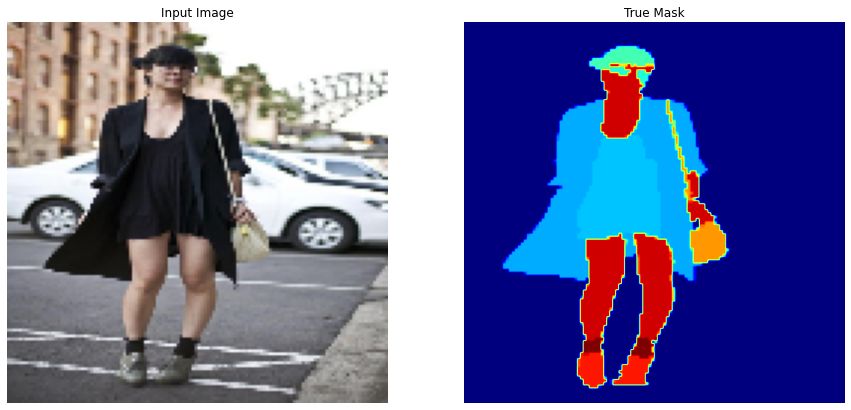

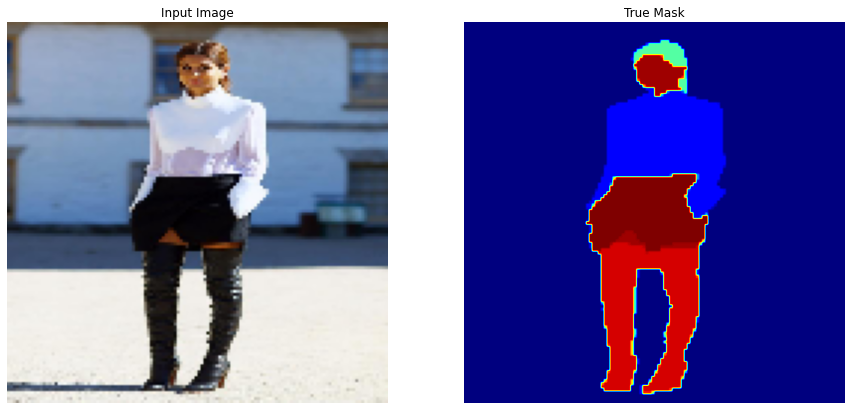

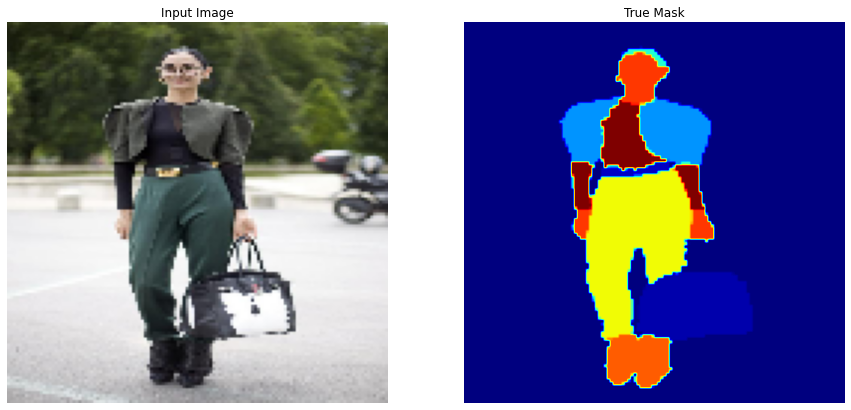

In [12]:
for i in range(10,13):
  sample_image, sample_mask = X[i], y[i]

  # tf.keras.utils.save_img(
  #       'test_sample_'+str(i)+'.jpg', sample_image
  #   )
  # tf.keras.utils.save_img(
  #       'test_sample__mask_'+str(i)+'.jpg', sample_mask
  #   )  

  visualizeData(display_list = [sample_image, sample_mask]).display()

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

### Split Data for training and validation

In [13]:
train_X, val_X, train_y, val_y = preprocessData.splitTrainTest(X,y)

TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None) TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None) TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None) TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None)


### Data Augmentation

In [14]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

# perform augmentation on train data only

a = train.map(preprocessData.brightness)
b = train.map(preprocessData.gamma)
c = train.map(preprocessData.hue)
d = train.map(preprocessData.crop)
e = train.map(preprocessData.flip_hori)
f = train.map(preprocessData.flip_vert)
g = train.map(preprocessData.rotate)

train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

### Define data and model Hyper paramether

In [15]:
BATCH = 64
AT = tf.data.AUTOTUNE
BUFFER = 1000

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

EPOCHS = 70
VAL_SUBSPLITS = 5



#### Prepare data in the form of batch processing

In [16]:
train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

## Define the model


### Define and compile the model 

In [17]:
model = buildModel().setupModel()

128 128 3
255
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 16)  5667664     ['input_2[0][0]']                
                                , (None, 32, 32, 12                                               
                                8),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                            

### Check for Model and Data compatibility

In [18]:
a,b = next(iter(train))
a.shape



2022-03-24 05:48:52.352259: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TensorShape([64, 128, 128, 3])

2022-03-24 05:48:53.194043: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


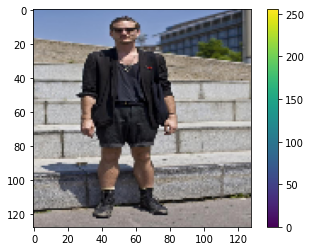

In [19]:
example = next(iter(train))
preds = model(example[0])
plt.imshow(tf.keras.utils.array_to_img(example[0][60]))

plt.colorbar()
plt.show()

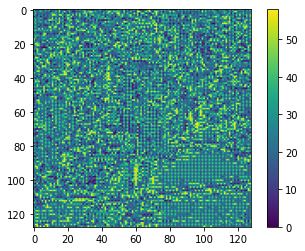

In [20]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0])
plt.colorbar()

In [21]:
from src import tasm

TOTAL_CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
N_TOTAL_CLASSES = 12
# CLASSES_DICT = {"sky": 0, "building": 1, "pole": 2, "road": 3, "pavement": 4,
#                 "tree": 5, "signsymbol": 6, "fence": 7, "car": 8,
#                 "pedestrian": 9, "bicyclist": 10, "unlabelled": 11}
# Dervied from Matlab: https://it.mathworks.com/help/vision/examples/semantic-segmentation-using-deep-learning.html
CLASSES_PIXEL_COUNT_DICT = {"sky": 76801000, "building": 117370000,
                            "pole": 4799000, "road": 140540000,
                            "pavement": 33614000, "tree": 54259000,
                            "signsymbol": 5224000, "fence": 69211000,
                            "car": 2437000, "pedestrian": 3403000,
                            "bicyclist": 2591000, "unlabelled": 0}

MODEL_CLASSES = ["sky", "building"]
BATCH_SIZE = 64
N_CLASSES = 59
HEIGHT = 128
WIDTH = 128
BACKBONE_NAME = "efficientnetn2s"
WEIGHTS = "imagenet"
WWO_AUG = True # train data with and without augmentation



base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

BACKBONE_TRAINABLE = True
model = tasm.DANet(n_classes=N_CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)

In [25]:
opt = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
            #  tf.keras.callbacks.ModelCheckpoint("DeepLabV3plus.ckpt", verbose=1, save_weights_only=True, save_best_only=True),
             DisplayCallback(model,sample_image,sample_mask),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

In [27]:
history = model.fit(
    train,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=100,
    validation_data=val,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks,
    )


# self.history = self.model.fit(
#             self.train_data,
#             epochs=self.epochs,
#               steps_per_epoch=self.step_per_epoch,
#               validation_steps=self.validation_steps,
#               validation_data=self.test_data,
#               callbacks=callbacks)

Epoch 1/100


InvalidArgumentError: in user code:

    File "/opt/app-root/src/Semantic-Image-Segmentation/src/tasm/base/objects.py", line 71, in __call__  *
        return self.l1(gt, pr) + self.l2(gt, pr)
    File "/opt/app-root/src/Semantic-Image-Segmentation/src/tasm/losses.py", line 112, in __call__  *
        y_pred,
    File "/opt/app-root/src/Semantic-Image-Segmentation/src/tasm/base/functional.py", line 117, in categorical_focal_loss  *
        loss = - y_true * (alpha * K.pow((1 - y_pred), gamma) * K.log(y_pred))

    InvalidArgumentError: Value for attr 'T' of uint8 is not in the list of allowed values: bfloat16, half, float, double, int8, int16, int32, int64, complex64, complex128
    	; NodeDef: {{node Neg}}; Op<name=Neg; signature=x:T -> y:T; attr=T:type,allowed=[DT_BFLOAT16, DT_HALF, DT_FLOAT, DT_DOUBLE, DT_INT8, DT_INT16, DT_INT32, DT_INT64, DT_COMPLEX64, DT_COMPLEX128]> [Op:Neg]


### Start Model Training

In [24]:


model, history = trainModel(model,train_data=train, test_data=val,validation_steps =VALIDATION_STEPS, step_per_epoch = STEPS_PER_EPOCH ,ckpp ='./models/SemImSeg_model_EfficientNetV2B0.h5',  val_subsplits = VAL_SUBSPLITS, batch_size=BATCH,epochs=EPOCHS,sample_image = sample_image ,sample_mask=sample_mask,display_callback =DisplayCallback).modelTraining()



Epoch 1/70


InvalidArgumentError: in user code:

    File "/opt/app-root/src/Semantic-Image-Segmentation/src/tasm/base/objects.py", line 71, in __call__  *
        return self.l1(gt, pr) + self.l2(gt, pr)
    File "/opt/app-root/src/Semantic-Image-Segmentation/src/tasm/losses.py", line 112, in __call__  *
        y_pred,
    File "/opt/app-root/src/Semantic-Image-Segmentation/src/tasm/base/functional.py", line 117, in categorical_focal_loss  *
        loss = - y_true * (alpha * K.pow((1 - y_pred), gamma) * K.log(y_pred))

    InvalidArgumentError: Value for attr 'T' of uint8 is not in the list of allowed values: bfloat16, half, float, double, int8, int16, int32, int64, complex64, complex128
    	; NodeDef: {{node Neg}}; Op<name=Neg; signature=x:T -> y:T; attr=T:type,allowed=[DT_BFLOAT16, DT_HALF, DT_FLOAT, DT_DOUBLE, DT_INT8, DT_INT16, DT_INT32, DT_INT64, DT_COMPLEX64, DT_COMPLEX128]> [Op:Neg]


#### Performance Curves

In [ ]:
history = model_history.history
acc=history['accuracy']
val_acc = history['val_accuracy']

plt.plot(acc, '-', label='Training Accuracy')
plt.plot(val_acc, '--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Thank you for your time!

In [ ]:
model = tf.keras.models.load_model('./models/SemImSeg_model_EfficientNetV2B0.h5')

## Make predictions

In [ ]:
img, mask = next(iter(val))
pred = model.predict(img)
plt.figure(figsize=(10,5))
for i in pred:
  
    print('####')
    plt.subplot(121)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')
    break
plt.subplot(122)
plt.imshow(mask[0], cmap='jet')
plt.axis('off')
plt.title('Ground Truth')
plt.show()

In [ ]:
import os
os.path.getsize('./models/SemImSeg_model_EfficientNetV2B0.h5')

##### Clean dataset folder

In [ ]:
os.system('rm -rf clone')